In [1]:
import os
import cv2 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.cluster import KMeans
from skimage.morphology import erosion, opening, square, \
                               disk, convex_hull_image
from skimage.measure import label
    
SMALL_FONT = 13
MEDIUM_FONT = 15
LARGE_FONT = 18

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_FONT)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


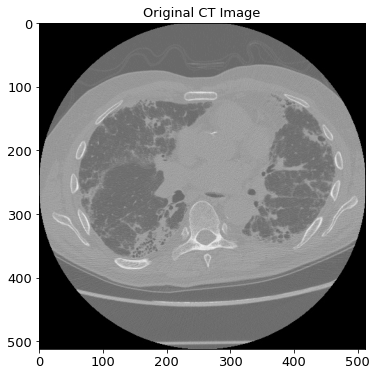

In [4]:
# Select a sample slice to work with
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('Original CT Image')
plt.imshow(im, cmap='gray')
print('Image Dimensions:', im.shape)

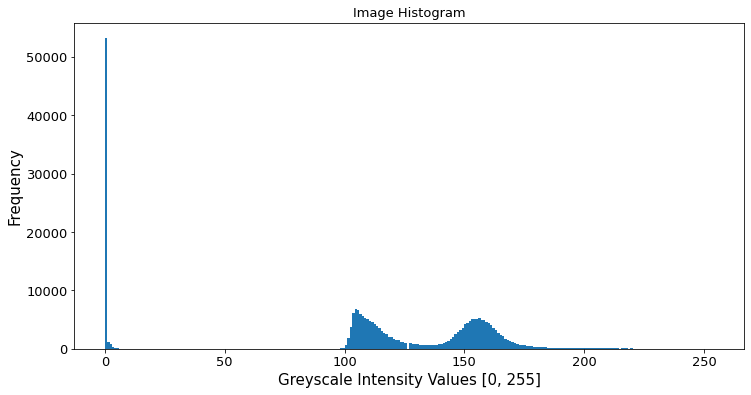

In [5]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [6]:
def plotSegmentedImg(img, segmented, K):
    
    # Plot the segmented image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    
    ax2.imshow(segmented)
    ax2.set_title('CT Image on Segmentation with KMeans of K = ' + str(K))

def plotHistogram(img, centers=None, kmmodel=None, threshold=None):
    plt.figure(figsize = (16, 8))

    if centers:
        colors = ['red', 'blue', 'green', 'purple', 'black']; i = 0

        # Center lines on the histogram
        for center in centers.values():
            plt.axvline(x = center, c = colors[i])
            plt.text(x = center + 5, 
                     y = 30000, 
                     s = "Center: " + str(center), 
                     c = colors[i])
            i+=1
    
    if threshold:
        plt.axvline(x = threshold, c = 'black')
        plt.text(x = threshold + 5, 
                 y = 20000, 
                 s = "Threshold: " + str(threshold), 
                 c = 'black')
            
    plt.title('Image Histogram')
    plt.xlabel('Greyscale Intensity Values [0, 255]')
    plt.ylabel('Frequency')


    N, bins, patches = plt.hist(img.ravel(), bins=256)

    if kmmodel:
        for i in range(0, len(bins) - 1):
            label = kmmodel.predict([[i]])
            patches[i].set_facecolor(colors[label[0]])

    #handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
    #labels = ["Air in the Chest", "Background Material", "Body Tissue and Bone"]
    #plt.legend(handles, labels)

    plt.show()

In [7]:
def applyKMeans(img, K, plot_segmented=0, plot_histogram=0):
    
    imgflat = np.reshape(img, img.shape[0] * img.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(K)
    
    kmmodel = kmeans.fit(imgflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    
    print(len(labels), 'Labels: \n', labels)
    
    # Center values correspond to intensity values 
    print(len(centers), 'Centers: \n', centers)
    
    # Print centers of labels
    centers_map = dict(zip(np.arange(K), centers))
    print('Labels with corresponding centers:', centers_map)
    
    segmented = np.array([centers_map[label] for label in labels]).reshape(img.shape[0], img.shape[1]) 

    segmented = segmented.astype(int)
    
    if plot_segmented:
        plotSegmentedImg(img, segmented, K)
    
    if plot_histogram:
        plotHistogram(img, centers_map, kmmodel)
    
    return segmented, labels, centers_map

262144 Labels: 
 [1 1 1 ... 1 1 1]
3 Centers: 
 [[1.57879115e+02]
 [8.82521695e-02]
 [1.12269714e+02]]
Labels with corresponding centers: {0: array([157.87911491]), 1: array([0.08825217]), 2: array([112.26971435])}


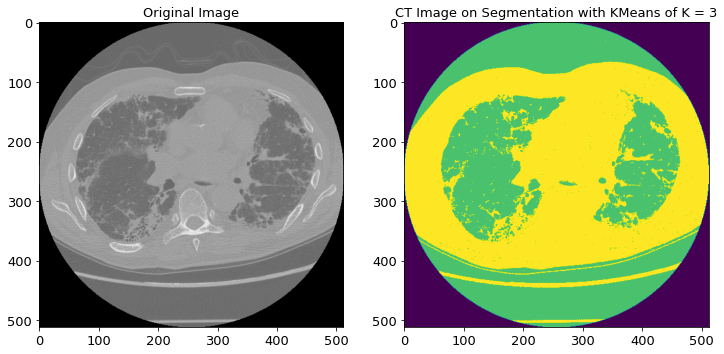

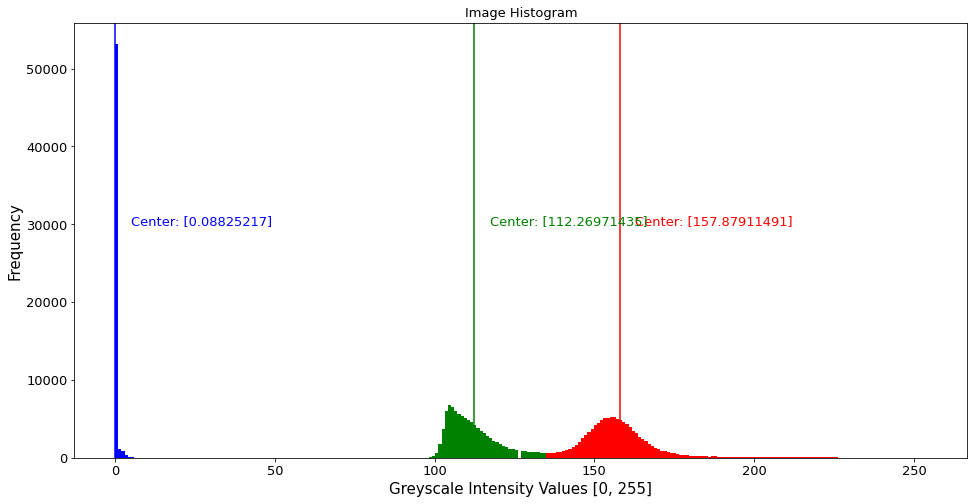

In [8]:
segmented, labels, centers = applyKMeans(im, 3, 1, 1)

In [9]:
centers

{0: array([157.87911491]), 1: array([0.08825217]), 2: array([112.26971435])}

In [10]:
center_values = [i[0] for i in centers.values()]
a = sorted(center_values)
threshold = (a[-1] + a[-2]) / 2

In [11]:
threshold

135.07441462746587

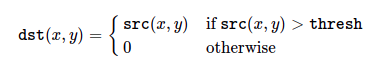

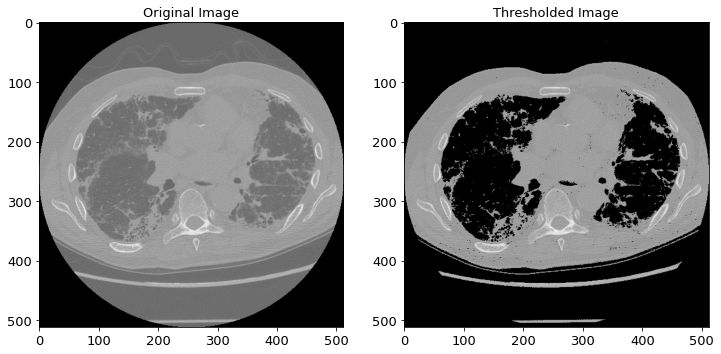

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title('Original Image')
ax1.imshow(im, cmap='gray')

retval, foreground = cv2.threshold(im, threshold, 255, cv2.THRESH_TOZERO) 
ax2.set_title('Thresholded Image')
ax2.imshow(foreground, cmap='gray')

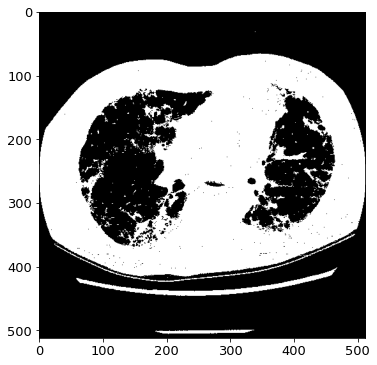

In [13]:
retval2, foreground_mask  = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY) 
plt.imshow(foreground_mask, cmap='gray')

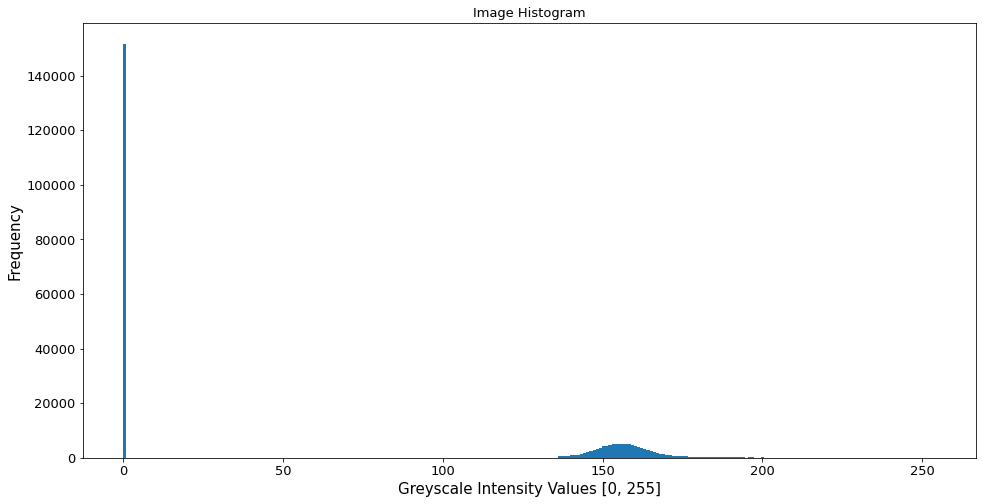

In [14]:
plotHistogram(foreground)

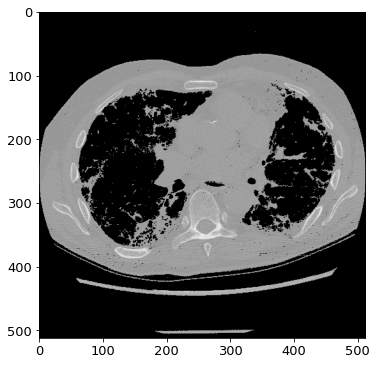

In [15]:
plt.imshow(foreground, cmap='gray')

Text(0.5, 1.0, 'opening(opening(opening(foreground)))')

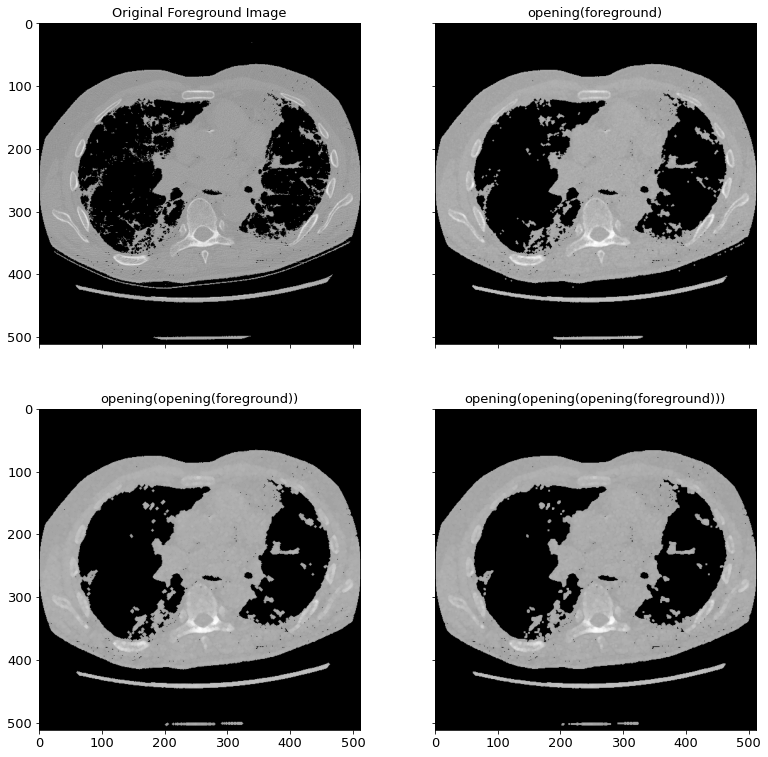

In [16]:
a = opening(foreground)
b = opening(a, disk(2))
c = opening(b, square(3))

fig, ax = plt.subplots(nrows=2,ncols=2,
                         sharex=True, sharey=True, 
                         figsize = (13, 13))
ax = ax.ravel()

ax[0].imshow(foreground, cmap='gray')
ax[0].set_title('Original Foreground Image')

ax[1].imshow(a, cmap='gray')
ax[1].set_title('opening(foreground)')

ax[2].imshow(b, cmap='gray')
ax[2].set_title('opening(opening(foreground))')

ax[3].imshow(c, cmap='gray')
ax[3].set_title('opening(opening(opening(foreground)))')

In [17]:
sum(sum(a - c))

66263

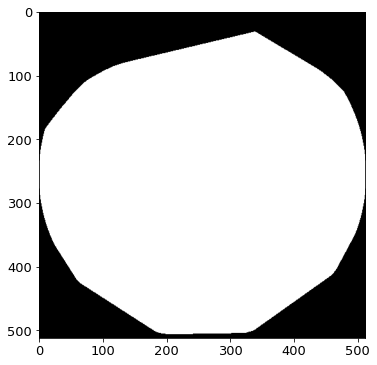

In [18]:
chull = convex_hull_image(foreground)
plt.imshow(chull, cmap='gray')

262144 Labels: 
 [0 0 0 ... 0 0 0]
3 Centers: 
 [[8.82521695e-02]
 [1.12269714e+02]
 [1.57879115e+02]]
Labels with corresponding centers: {0: array([0.08825217]), 1: array([112.26971435]), 2: array([157.87911491])}


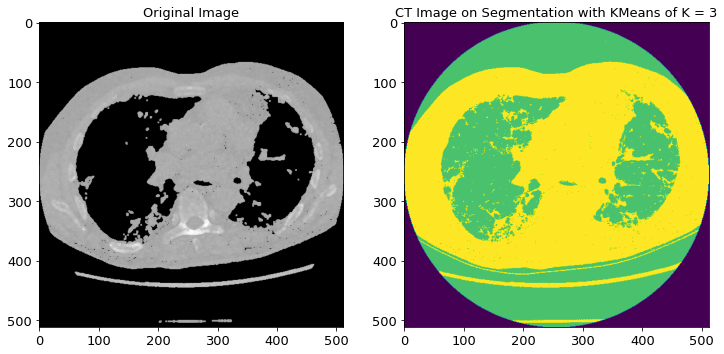

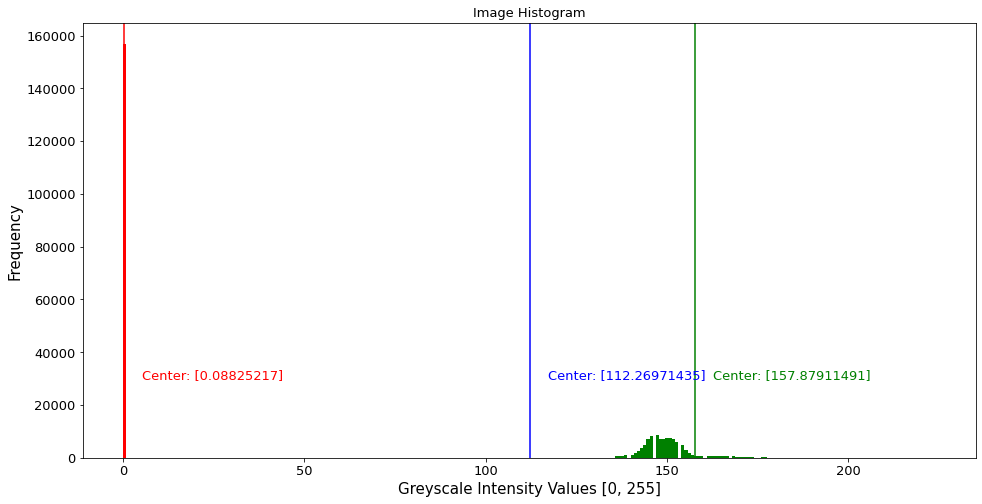

In [19]:
a = applyKMeans(c, 3, 1, 1)